-----------------

# Assessing Read Quality

This notebook introduces the bioinformatics pipeline process and takes a deeper look at the quality control process. An overview on the Sequence Read Archive is given as we'll be using this database to download the data we'll be working with. We'll be running our bioinformatics tools in containers using apptainer on the HPC. We'll also be running all of our jobs with scripts that rub the containers in-parallel.

###### A note on using the HPC and SBATCH tools --
While we can stay in a Jupyter notebook with some work around, it's easier and more prudent in future bioinformatics work to get used to writing/running scripts and tools in the command line. We'll be using this notebook as a guide and reference for our scripts but we'll have a terminal open in another tab/window to execute our commands. 

-----

Sections:
1. Bioinformatic Workflow Introduction
2. The Quality Control Process
3. Downloading SRA Access Lists from the NCBI
4. Hands-on Example using Sbatch to run jobs in parallel

-----

A few good resources to help:

1. A introduction to the [HPC](https://www.youtube.com/watch?v=xlgL6u1jkVI&ab_channel=UniversityofArizonaUITSResearchTechnologies)
2. An introduction to parallel computing on the [HPC](https://www.youtube.com/watch?v=3Qwhlihf9wc)
3. A link to the github repo from the HPC that has [script examples](https://ua-researchcomputing-hpc.github.io/)

## 1. Bioinformatic Workflows

High-throughput sequencing requires you to complete a series of different steps to get your final data format. Once you have your sequence reads, you'll run through a quality control stage. After you assemble the metagenome, then bin (cluster the contigs into genome bins), and finally determine the taxonomy. The steps use different file formats, requiring specific tools to process the data. These sequential steps are called pipelines. 

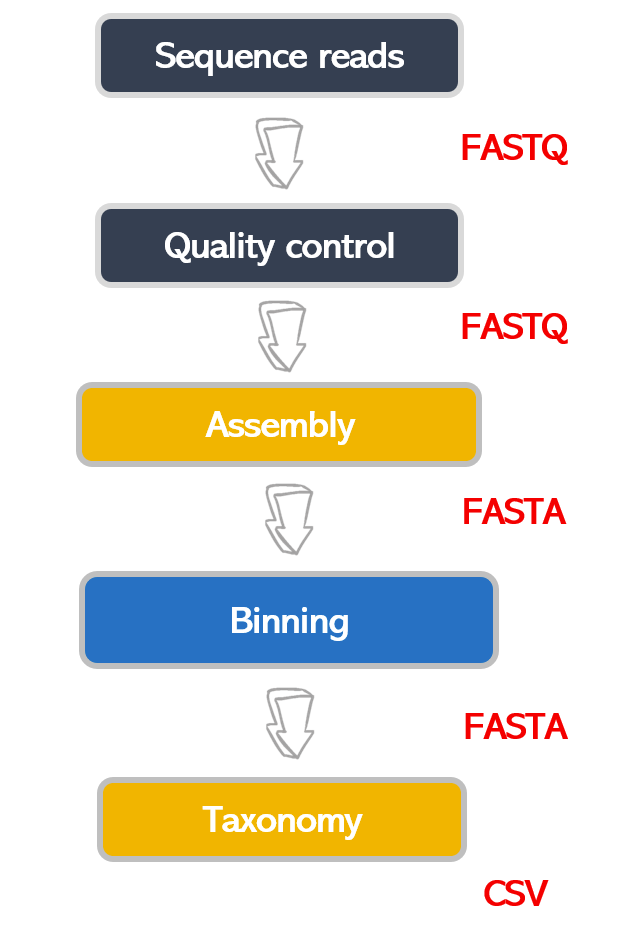

This notebook will be focusing on an early step – Quality Control (QC), using the FASTQ file type.
In short, once your sequencer processes your samples, you’ll have a FASTQ file to go through quality control. The FASTQ format is complicated to hand-read but the tools we utilize make it a simpler process. It’s still important to know the components of a FASTQ file;

1.	All reads start with an “@” symbol, along with other meta-information (id, time, etc.)
2.	The actual DNA sequence.
3.	A “+” sign denotes the Q part of the file.
4.	A string of characters that represent quality scores based of the Sanger PHRED score. It’s important to note there needs to be as many characters as there are DNA nucleotides.  

We're summarizing the initial QC process but if you'd like more information about FASTQ files you can read about it [here](https://carpentries-lab.github.io/metagenomics-analysis/02-assessing-read-quality/index.html).

-----


## 2. The QC Process

The quality of our data needs to be assessed before use. The quality scores we see in our FastQ files are interpreted as the probability of an incorrect base call – it’s the base accuracy with each nucleotide converted into one of the special characters. Each nucleotide will have it’s own score, so each corresponding character shows the probability that the nucleotide sampled is incorrect. The algorithm used is log based. A quality score of 10 represents an accuracy of 90%, and a score of 20 represents 99% accuracy. Info on Phred scores can be found [here](https://drive5.com/usearch/manual/quality_score.html).

FastQC is a tool that gives you a visual representation of your reads. It develops plots across all reads within a sample, broken up by base pair. The x-axis shows the BPs, and the y-axis shows the quality scores. Each BP is set up in a box and whisker plot. Each sample will require its own FastQC report. Meaning if you have 47 samples, you’ll be looking at 47 QC reports. The purpose of the QC process is to determine if you need to trim your data at a specific BP, scrap a sample entirely, or if possible, re-sequence. 

![FastQC_Plot2.PNG](attachment:FastQC_Plot2.PNG "FASTQC Example Plot")

-----

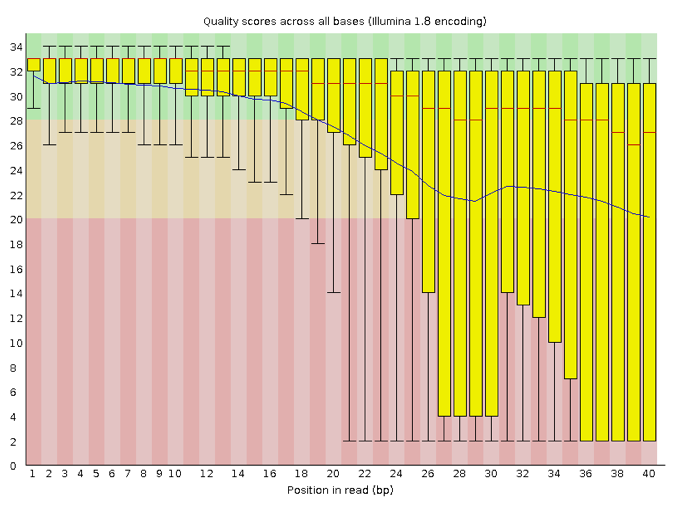

## 3. Downloading SRA Accession List from the NCBI

When reading through a study, often where the data set can be accessed is at the bottom of a study. The National Library of Medicine's National Center for Biotechnology Information [(NCBI)](https://www.ncbi.nlm.nih.gov/) has a database called the Sequence Read Archive (SRA) that works as a mastering sequencing archive for all data in the world. <br>

![Data_Set1.PNG](attachment:Data_Set1.PNG "Study showing Data Link")
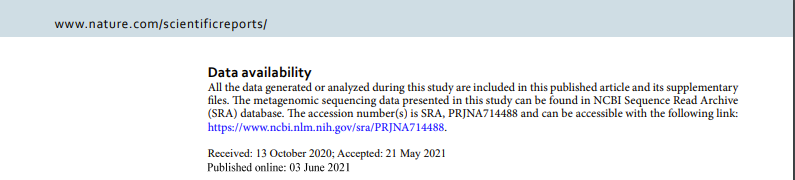

#### When you land on the page, make sure you’re searching under the SRA category. 

![Data_Set2.PNG](attachment:Data_Set2.PNG "SRA Category Selection")

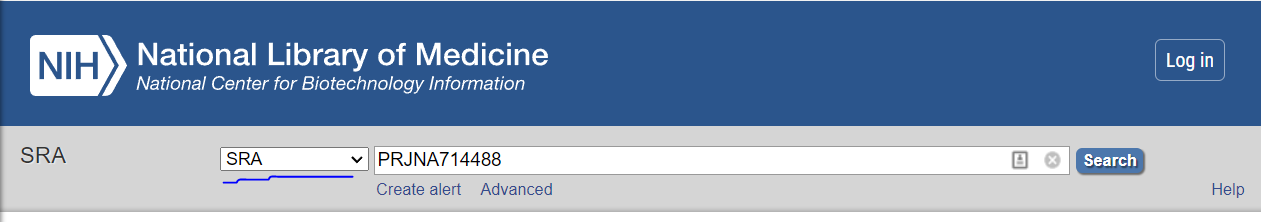

#### Clicking on an archive opens a page with some information about the submission. Scroll down to the project data portion and click on the number under “Sequence Data”.

![Data_Set3.PNG](attachment:Data_Set3.PNG "Sample Information Page")
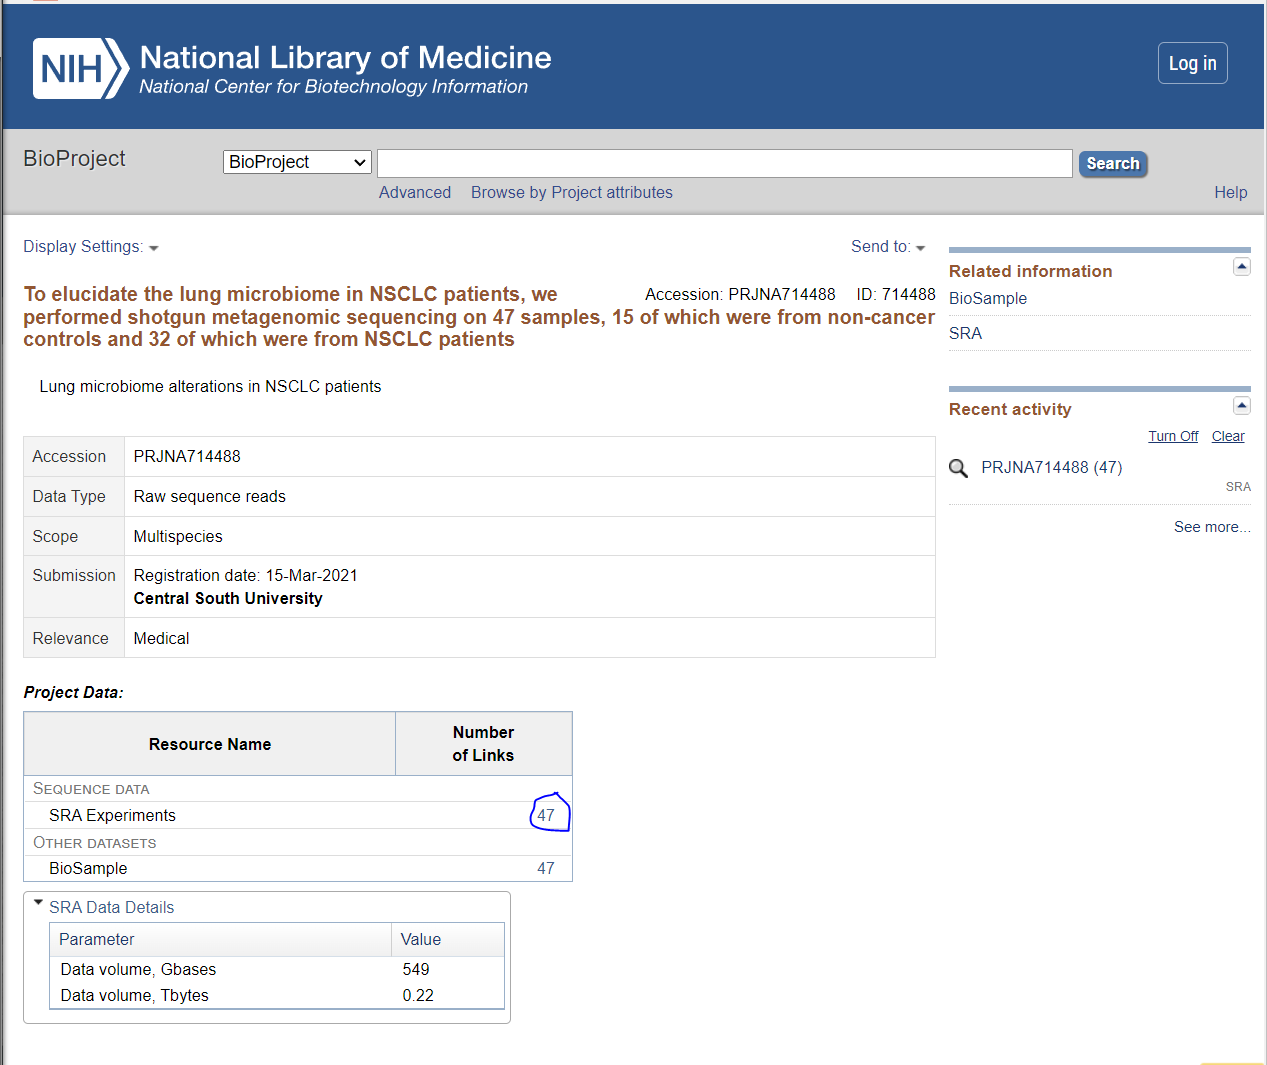

####  Next, we select the sequences we want and send to the run selector. 

![Data_Set4.PNG](attachment:Data_Set4.PNG "Run Selector Example")
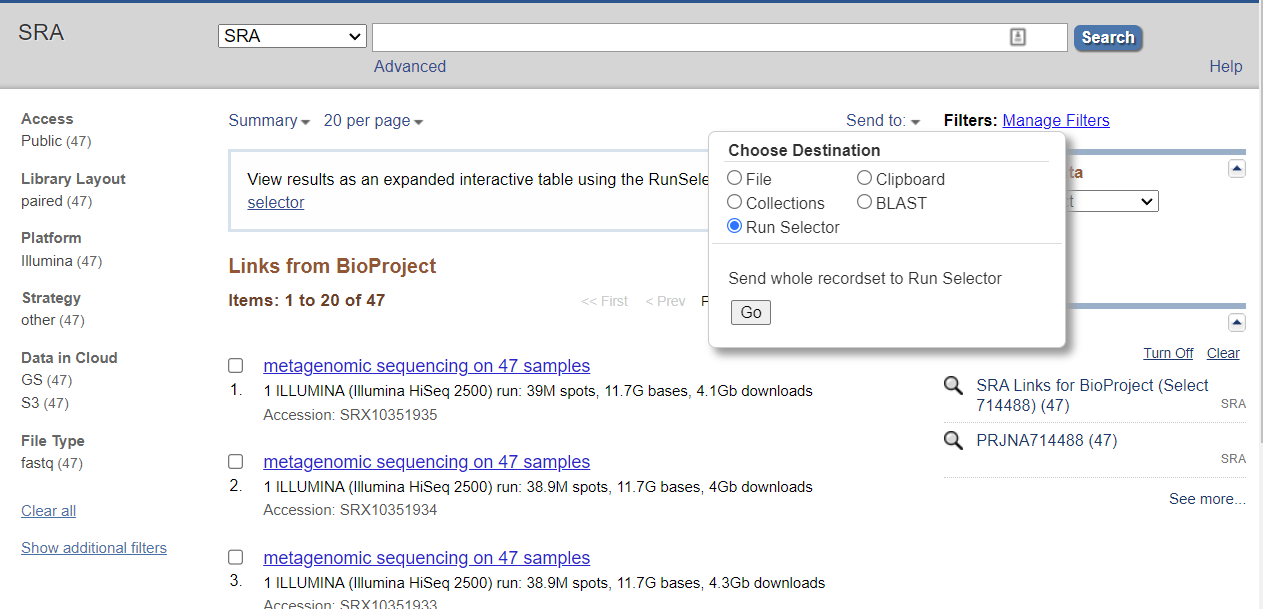

#### This page shows each sample along with different filters and metadata. We need the SRA Accession List for all the samples, so we’ll select the “Accession List” button for the total samples. This will deliver a text doc titles “SRR_Acc_List.txt” which we’ll use in a tool to download the data. 

![Data_Set5.PNG](attachment:Data_Set5.PNG "Accession List")
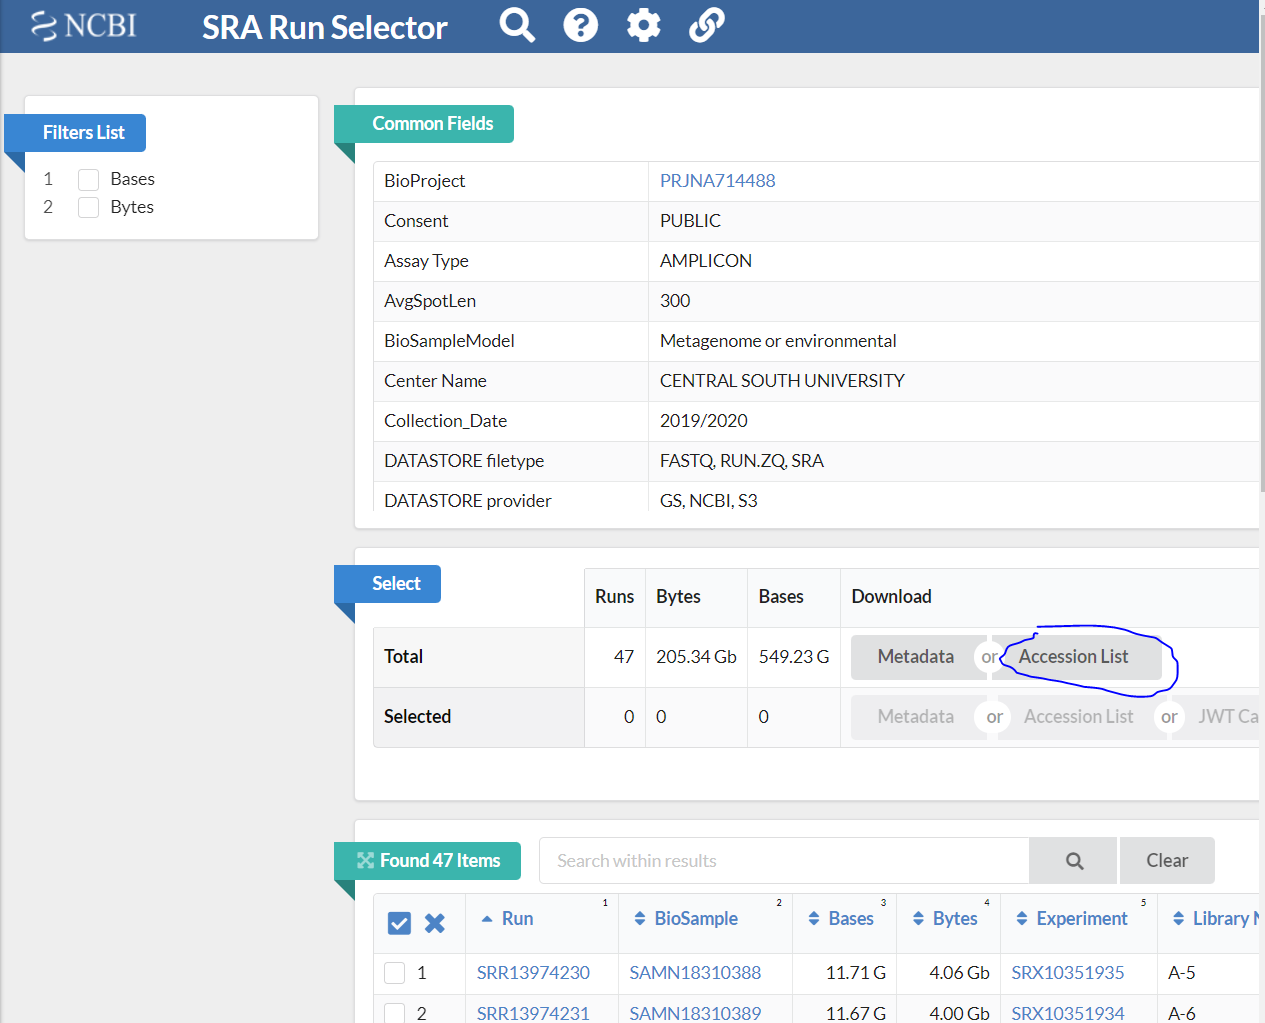

------

## 4. Hands-on Example using Sbatch to run jobs in parallel

In [ ]:
cd /xdisk/bhurwitz/YOUR_NAME #Moving to our xdisk location on the HPC
mkdir bio_pipeline  #Creating the main directory for all our files
cd bio_pipeline #moving into that directory
mkdir data read_quality trimming assembly check_assembly #child directories for each step

#### Download the SRR_Acc_List from the study below

https://www.ncbi.nlm.nih.gov/bioproject/?term=PRJNA714488. 

Upload the SRA file of accessions to the **/xdisk/bhurwitz/YOUR_NAME/bio_pipeline/data** folder prior to running this notebook. The file is typically called: SRR_Acc_List.txt. We'll be using the different IDs for our various tools. We're using the xdisk because the size of the sample files are too big for our storage limits.

We'll be setting up our file structure early to manage all the various file outputs we'll be getting. 

We'll be using an SRA toolkit, which works on a container. The UA HPC requires we use apptainer to store the container image, we we'll be using that tool to hold and run our bioinformatics tools. 

### 01_Parallel Prefetching

This will be our first script to run our jobs in parallel on the HPC. We'll be using the nano text editor in the command line. It's good practice to have a common place to save and run your scripts. I save mine in my home directory inside scripts directory which I can easily access later by using the tilde to reference my home

~/scripts/SCRIPT_NAME.sh

In [ ]:
cd $HOME
mkdir scripts

In [ ]:
!nano ~/scripts/prefetch_parallel.sh #writing a script in nano that saves to a scripts folder in my home directory

##### An explanation of an SBATCH script --

Let's look at the script below to explain what each component is starting with the header data:

    - ntasks are the amount of jobs each separate cluster will run. If you run multiple apptainer tasks, update the number.
    - nodes are the amount of clusters you're requesting for each job, typically it'll stay 1.
    - time is the max amount a job can run, depending on your data it'll vary but the lower the amount of
      resources you request, the faster your job will get picked up by the scheduler.  
    - parition and account will typically stay the same, it's based on the PI's account you're using.
    - array is the ammount of jobs you'll be running. Since our SRR_ACC_List contains 47 SRR id numbers, our array is 47.
    - output is the title of a txt file where the output from the tool is stored for later reference.
    - cpus & mem are resource allocations for different tasks. Different tools have different speeds, but the more resources
      you request the harder it is for your job to get picked up. 
      
Now let's look at the actual script:

    - pwd; hostname; date just provides some output data so we can see basic info about each job
    - names=($(cat SRR_Acc_List.txt)) stores all 47 id numbers in an array within the variable name
    - echo $(names[$SLURM_ARRAY_TASK_ID}]} prints out the current SRR number we're working on. 
      It uses the SLURM_ARRAY_TASK_ID to index the names array.
    - apptainer run... this runs the actual tool from the shared tools folder on the server. We're requesting a prefetch and
      using our array to select one of the 47 IDs based on the SLURM_ARRAY_TASK_ID

In [ ]:
#!/bin/bash
#SBATCH --ntasks=1
#SBATCH --nodes=1             
#SBATCH --time=10:00:00   
#SBATCH --partition=standard
#SBATCH --account=bhurwitz
#SBATCH --array=0-46                           
#SBATCH --output=Job-%a.out
#SBATCH --cpus-per-task=1                    
#SBATCH --mem=4G                             
 
#SLURM Inherits your environment. cd $SLURM_SUBMIT_DIR not needed
pwd; hostname; date
 
names=($(cat /xdisk/bhurwitz/YOUR_NAME/bio_pipeline/data/SRR_Acc_List.txt))
 
echo ${names[${SLURM_ARRAY_TASK_ID}]}

#we don't need option -file since we're using $names to process through the SRR_Acc_List

apptainer run /contrib/singularity/shared/bhurwitz/sra-tools-3.0.3.sif prefetch ${names[${SLURM_ARRAY_TASK_ID}]}

#### Change into the directory where we want our output files to be.

Let's change into our /xdisk/bhurwitz/YOUR_NAME/bio_pipeline/data directory to store our initial data.

In [ ]:
%cd /xdisk/bhurwitz/YOUR_NAME/bio_pipeline/data

#### Now let's sbatch our pre-fetch code

In [ ]:
!sbatch ~/scripts/prefetch_parallel.sh

###### Output files of the parallel prefetch

After the job runs we'll see that we have multiple files in our directory. A Job-*.out and a SRR directory that matches each of the ID's from the SRR_Acc_List.txt. Let's continue our data management and move all these files into our data folder we created earlier.

As you get comfortable writing scripts you can add data management commands to move the output into specific locations

In [ ]:
mv *.out SRR1* data

### 02_Parallel FastQ Collection

We'll now run another tool to complete the prefetch process and gather our fastq files. This uses the directories with the SRR identification number.

Here's the [documentation](https://github.com/ncbi/sra-tools/wiki/HowTo:-fasterq-dump).

In [ ]:
nano ~/scripts/fasterq_parallel.sh

In [ ]:
#!/bin/bash
#SBATCH --ntasks=1
#SBATCH --nodes=1             
#SBATCH --time=10:00:00   
#SBATCH --partition=standard
#SBATCH --account=bhurwitz
#SBATCH --array=0-46                         
#SBATCH --output=Job-%a.out
#SBATCH --cpus-per-task=1                   
#SBATCH --mem=4G                            
 
# SLURM Inherits your environment. cd $SLURM_SUBMIT_DIR not needed
pwd; hostname; date
 
names=($(cat /xdisk/bhurwitz/YOUR_NAME/bio_pipeline/data/SRR_Acc_List.txt))

echo ${names[${SLURM_ARRAY_TASK_ID}]}

apptainer run /contrib/singularity/shared/bhurwitz/sra-tools-3.0.3.sif fasterq-dump --split-files \
    ${names[${SLURM_ARRAY_TASK_ID}]}

In [ ]:
sbatch ~/scripts/fasterq_parallel.sh

##### Output files of the fasterq collection

We'll recieve two fastq files for paired end data. In our script we added another task to move all _*.fastq files into the data directory for better data management

In [ ]:
mv *.fastq data

### 03_Parallel_Assessing Read Quality

We'll now move onto the next step in the quality control process -- generating reports on what our data looks like using the fastqc tool. We'll run multiple tasks in this script to move the report and zip files into our read_quality directory into it's own result directory


In [ ]:
mkdir /xdisk/bhurwitz/YOUR_NAME/read_quality/results #prep the results directory for the script

In [ ]:
nano ~/scripts/fastq_reads_parallel.sh

In [ ]:
#!/bin/bash
#SBATCH --ntasks=3
#SBATCH --nodes=1             
#SBATCH --time=10:00:00   
#SBATCH --partition=standard
#SBATCH --account=bhurwitz
#SBATCH --array=0-46                          
#SBATCH --output=Job-%a.out
#SBATCH --cpus-per-task=1                  
#SBATCH --mem=4G                           

pwd; hostname; date
 
names=($(cat /xdisk/bhurwitz/YOUR_NAME/bio_pipeline/data/SRR_Acc_List.txt))
readdir="/xdisk/bhurwitz/YOUR_NAME/data"

apptainer run /contrib/singularity/shared/bhurwitz/fastqc-0.11.9.sif fastqc \
    ${readdir}/${names[${SLURM_ARRAY_TASK_ID}]}_*.fastq*
mv ${readdir}/*.zip read_quality/results
mv ${readdir}/*.html read_quality/results

In [ ]:
sbatch ~/scripts/fastq_reads_parallel.sh

##### Output files of the fastqc

Within our results directory we'll now have two files generated from the fastqc tool for each SRA identification number; a .html and .zip folder. We can run a quick loop to process all the txt reports. If we want to view the graphical HTML files, we can move them into our home directory and access them through our jupyter server GUI.


In [ ]:
cd read_quality/results
mkdir zippedfiles
mv *.zip zippedfiles
cd zippedfiles
unzip \*fastqc.zip
cat *_fastqc/summary.txt > ../results.txt

In [ ]:
mv prefetch/*.html $HOME/reports #this will send all htmls into a directory called reports.

## Decoding the other FastQC outputs

Here is a brief overview of interpretations for each plot. For more information, please see the FastQC documentation [here](https://www.studocu.com/en-us/document/studocu-university/biologia-molecular/fast-qc-manual-adsdadadadadadad/44326937)

Per tile sequence quality: the machines that perform sequencing are divided into tiles. This plot displays patterns in base quality along these tiles. Consistently low scores are often found around the edges, but hot spots could also occur in the middle if an air bubble was introduced during the run.
Per sequence quality scores: a density plot of quality for all reads at all positions. This plot shows what quality scores are most common.

Per base sequence content: plots the proportion of each base position over all of the reads. Typically, we expect to see each base roughly 25% of the time at each position, but this often fails at the beginning or end of the read due to quality or adapter content.

Per sequence GC content: a density plot of average GC content in each of the reads.

Per base N content: the percent of times that ‘N’ occurs at a position in all reads. If there is an increase at a particular position, this might indicate that something went wrong during sequencing.

Sequence Length Distribution: the distribution of sequence lengths of all reads in the file. If the data is raw, there is often a sharp peak; however, if the reads have been trimmed, there may be a distribution of shorter lengths.

Sequence Duplication Levels: a distribution of duplicated sequences. In sequencing, we expect most reads to only occur once. If some sequences are occurring more than once, it might indicate enrichment bias (e.g. from PCR). This might not be true if the samples are high coverage (or RNA-seq or amplicon).

Overrepresented sequences: a list of sequences that occur more frequently than would be expected by chance.

Adapter Content: a graph indicating where adapater sequences occur in the reads.

K-mer Content: a graph showing any sequences which may show a positional bias within the reads.

-----